### packages and loading functions 

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

In [2]:
def imshow(image=None, title="sample image", cmap=None):
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.show()

In [3]:
model_file_path = "NeuralStyleTransfer/models/"
model_file_paths = [f for f in listdir(model_file_path) if isfile(join(model_file_path, f))]

print(model_file_paths)

ecc_model_file_path = "NeuralStyleTransfer/models/ECCV16"
ecc_model_file_paths = [f for f in listdir(ecc_model_file_path) if isfile(join(ecc_model_file_path, f))]

print(ecc_model_file_paths)

['candy.t7', 'composition_vii.t7', 'feathers.t7', 'la_muse.t7', 'mosaic.t7', 'starry_night.t7', 'the_scream.t7', 'the_wave.t7', 'udnie.t7']
['composition_vii.t7', 'la_muse.t7', 'starry_night.t7', 'the_wave.t7']


In [4]:
def cache_all_models(paths):
    models_cache = {}
    model_file_path = "NeuralStyleTransfer/models/"
    art_file_path = "NeuralStyleTransfer/art/"
    for model in paths:
        nst_model = cv2.dnn.readNetFromTorch(model_file_path+model)
        style = cv2.imread(art_file_path+str(model)[:-3]+".jpg")
        models_cache[model[:-3]] = [nst_model, style]

    ecc_models_cache = {}
    ecc_model_file_path = "NeuralStyleTransfer/models/ECCV16/"
    for model in ecc_model_file_paths:
        ecc_nst_model = cv2.dnn.readNetFromTorch(ecc_model_file_path+model)
        ecc_models_cache[model[:-3]] = [ecc_nst_model, None]

    return [models_cache, ecc_models_cache]

all_models_cached = cache_all_models(model_file_paths)
models_cache, ecc_models_cache = all_models_cached

In [5]:
def gen_in_style_of(style=None, img=None, models=all_models_cached, ECC=False):

    models = all_models_cached[1] if ECC else all_models_cached[0]
    if style == None: print('Enter valid style')
    elif not style in models.keys(): print(f'Unsupported style: {style}\nUse one of the following: {list(models.keys())}')
    else: 
        # loading cached models for style
        nst_model, _ = models[style]

        # resize 
        height, width = int(img.shape[0]), int(img.shape[1])
        newWidth = int((640 / height) * width)
        resizedImg = cv2.resize(img, (newWidth, 640), interpolation = cv2.INTER_AREA)

        # preprocess image for forward pass
        inpBlob = cv2.dnn.blobFromImage(resizedImg, 1.0, (newWidth, 640), (103.939, 116.779, 123.68), swapRB=False, crop=False)
        nst_model.setInput(inpBlob)
        output = nst_model.forward()

        # reshape and normalize for output image
        output = output.reshape(3, output.shape[2], output.shape[3])
        output[0] += 103.939
        output[1] += 116.779
        output[2] += 123.68 
        output /= 255
        output = output.transpose(1, 2, 0)
        
        # output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)

        return output

### available styles sample images

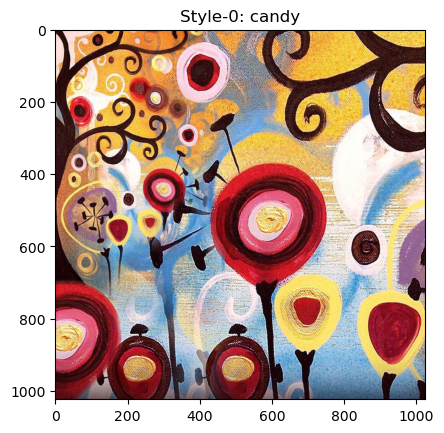

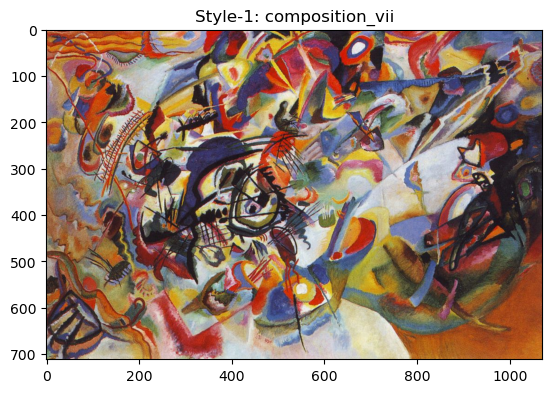

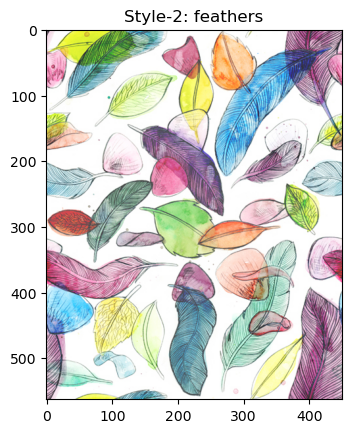

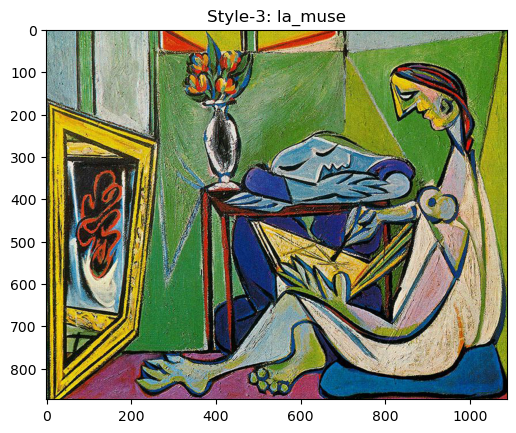

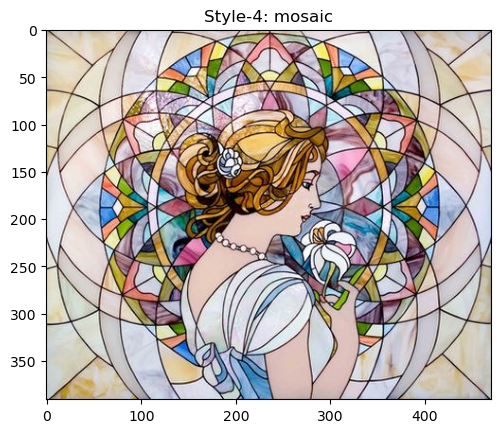

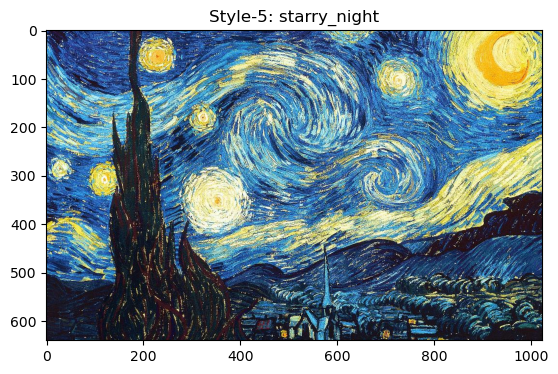

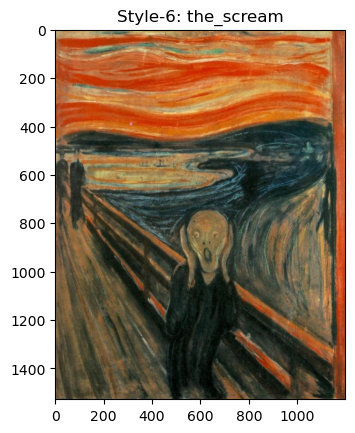

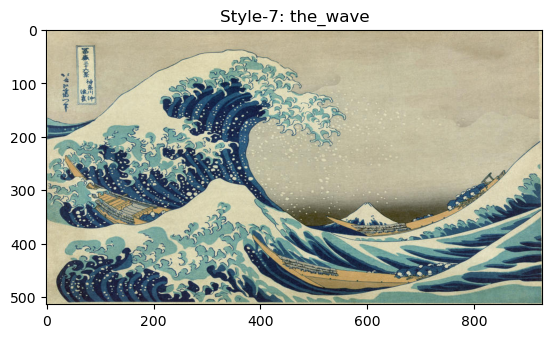

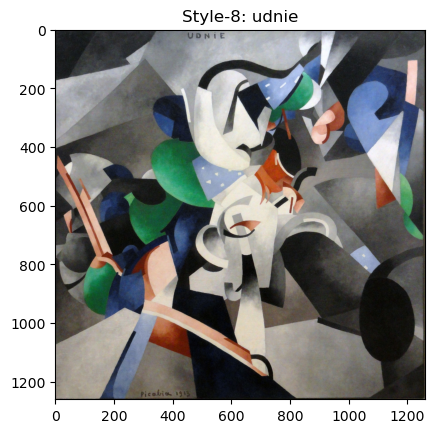

In [6]:
for i, (style) in enumerate(models_cache):
    imshow(cv2.cvtColor(models_cache[style][1], cv2.COLOR_RGB2BGR), f"Style-{i}: {style}")

### load video from webcam

In [13]:
if __name__ == '__main__':

    # options: ['candy', 'composition_vii', 'feathers', 'la_muse', 'mosaic', 'starry_night', 'the_scream', 'the_wave', 'udnie']
    style = 'mosaic'
    cap = cv2.VideoCapture(0)
           
    # start capturing from cam
    while True:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
       
        # show original frame
        cv2.imshow('original frame', frame)
        
        # transform fram in style using NST 
        transform = gen_in_style_of(style, frame)

        cv2.imshow(f'frame w/ style-{style}', transform)
       
        # press 'q' to quit capturing frames
        if cv2.waitKey(1) == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

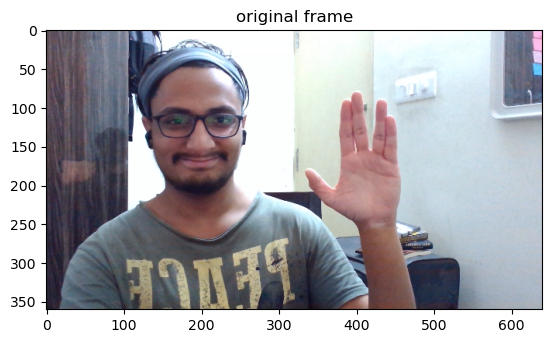

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


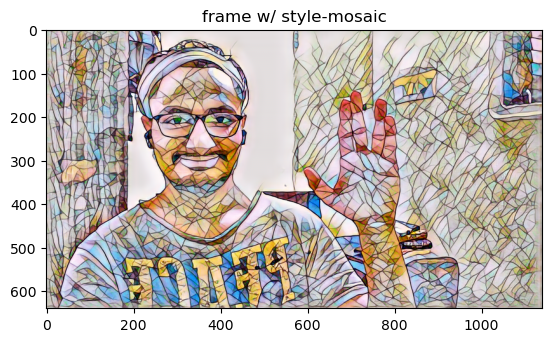

In [14]:
imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 'original frame')
imshow(cv2.cvtColor(transform, cv2.COLOR_BGR2RGB), f'frame w/ style-{style}')